# Lecture 13
_____________


In [28]:
import numpy as np 
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 600
from scipy.optimize import minimize, differential_evolution

## _Hedging - optimization_

The policy is defined by two parameters $(h_0, h_f)$. The simulate function is used to evaluate the policy. 

In [29]:
K = 975 # capacity, TAF
D = 150 # target yield, TAF
a = 1
b = 2 # cost function parameters

In [40]:
Q = np.loadtxt('data/FOL-monthly-inflow-TAF.csv', delimiter=',', 
               skiprows=1, usecols=[1])
T = len(Q)

def simulate(x): # the simulate function is the objective function
    S = np.zeros(T)
    R = np.zeros(T)
    cost = np.zeros(T)
    h0 = x[0]
    hf = x[1]
    
    S[0] = K # start simulation full
    
    for t in range(1,T):
        
        # new storage: mass balance, max value is K
        S[t] = min(S[t-1] + Q[t-1] - R[t-1], K)
        
        # determine R from hedging policy
        W = S[t] + Q[t]
        if W > hf:
            R[t] = D
        elif W < h0:
            R[t] = W
        else:
            R[t] = (D-h0)/(hf-h0)*(W-h0)+h0
        
        shortage = D-R[t]
        cost[t] = a*shortage**b # changing the exponent reflects the value of hedging
    
    #print('h0 = %f, hf = %f, cost = %f' % (h0,hf,cost.mean()))
    return cost.mean()

To use __gradient-based optimization__...

In [41]:
res = minimize(simulate, # minimize the cost from the simulate function
               x0=[65,820], # initial guess
               bounds = [(0,D), (D,K+D)]) # upper and lower bounds on the decision variables

In [42]:
print(res)

      fun: 482.826315864372
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00698037,  0.01764987])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 216
      nit: 20
     njev: 72
   status: 0
  success: True
        x: array([ 62.87664334, 808.30420472])


The gradient-based search will converge to different solutions depending on the initial guess. These are local optima, and multi-start gradient search may be needed to find the global optimum.

From `scipy` we can also try an evolutionary algorithm:

In [43]:
res = differential_evolution(simulate,
                             bounds = [(0,D), (D,K+D)]) # lower and upper bounds for the decision variables

`res.x` contains the optimal $(h_0,h_f)$ values

`res.fun` is the optimal (minimum) function value

In [44]:
print(res)

     fun: 482.8263155837427
     jac: array([-0.00677005,  0.01762145])
 message: 'Optimization terminated successfully.'
    nfev: 426
     nit: 6
 success: True
       x: array([ 62.87750357, 808.3045235 ])


The EA can converge to different solutions because of randomness. It does not use an initial guess, instead it uses a set of solutions to explore the space of possible policies. In this case the solutions end up being similar to the gradient search, but with a different $x_0$ for the gradient search that may not be the case.

-------------

## _Hedging - contour plots_

To make a contour plot...

In [50]:
h0s = np.arange(0,D,5)
hfs = np.arange(D,K+D,5)

# Or, ranges for zoomed-in contour plot
h0s = np.arange(60,90,0.5)
hfs = np.arange(800,855,0.5)

In [51]:
data = np.zeros((len(h0s),len(hfs)))
i,j = 0,0

for h0 in h0s:
    for hf in hfs:
        data[i,j] = simulate([h0,hf])
        j += 1
    j = 0
    i += 1

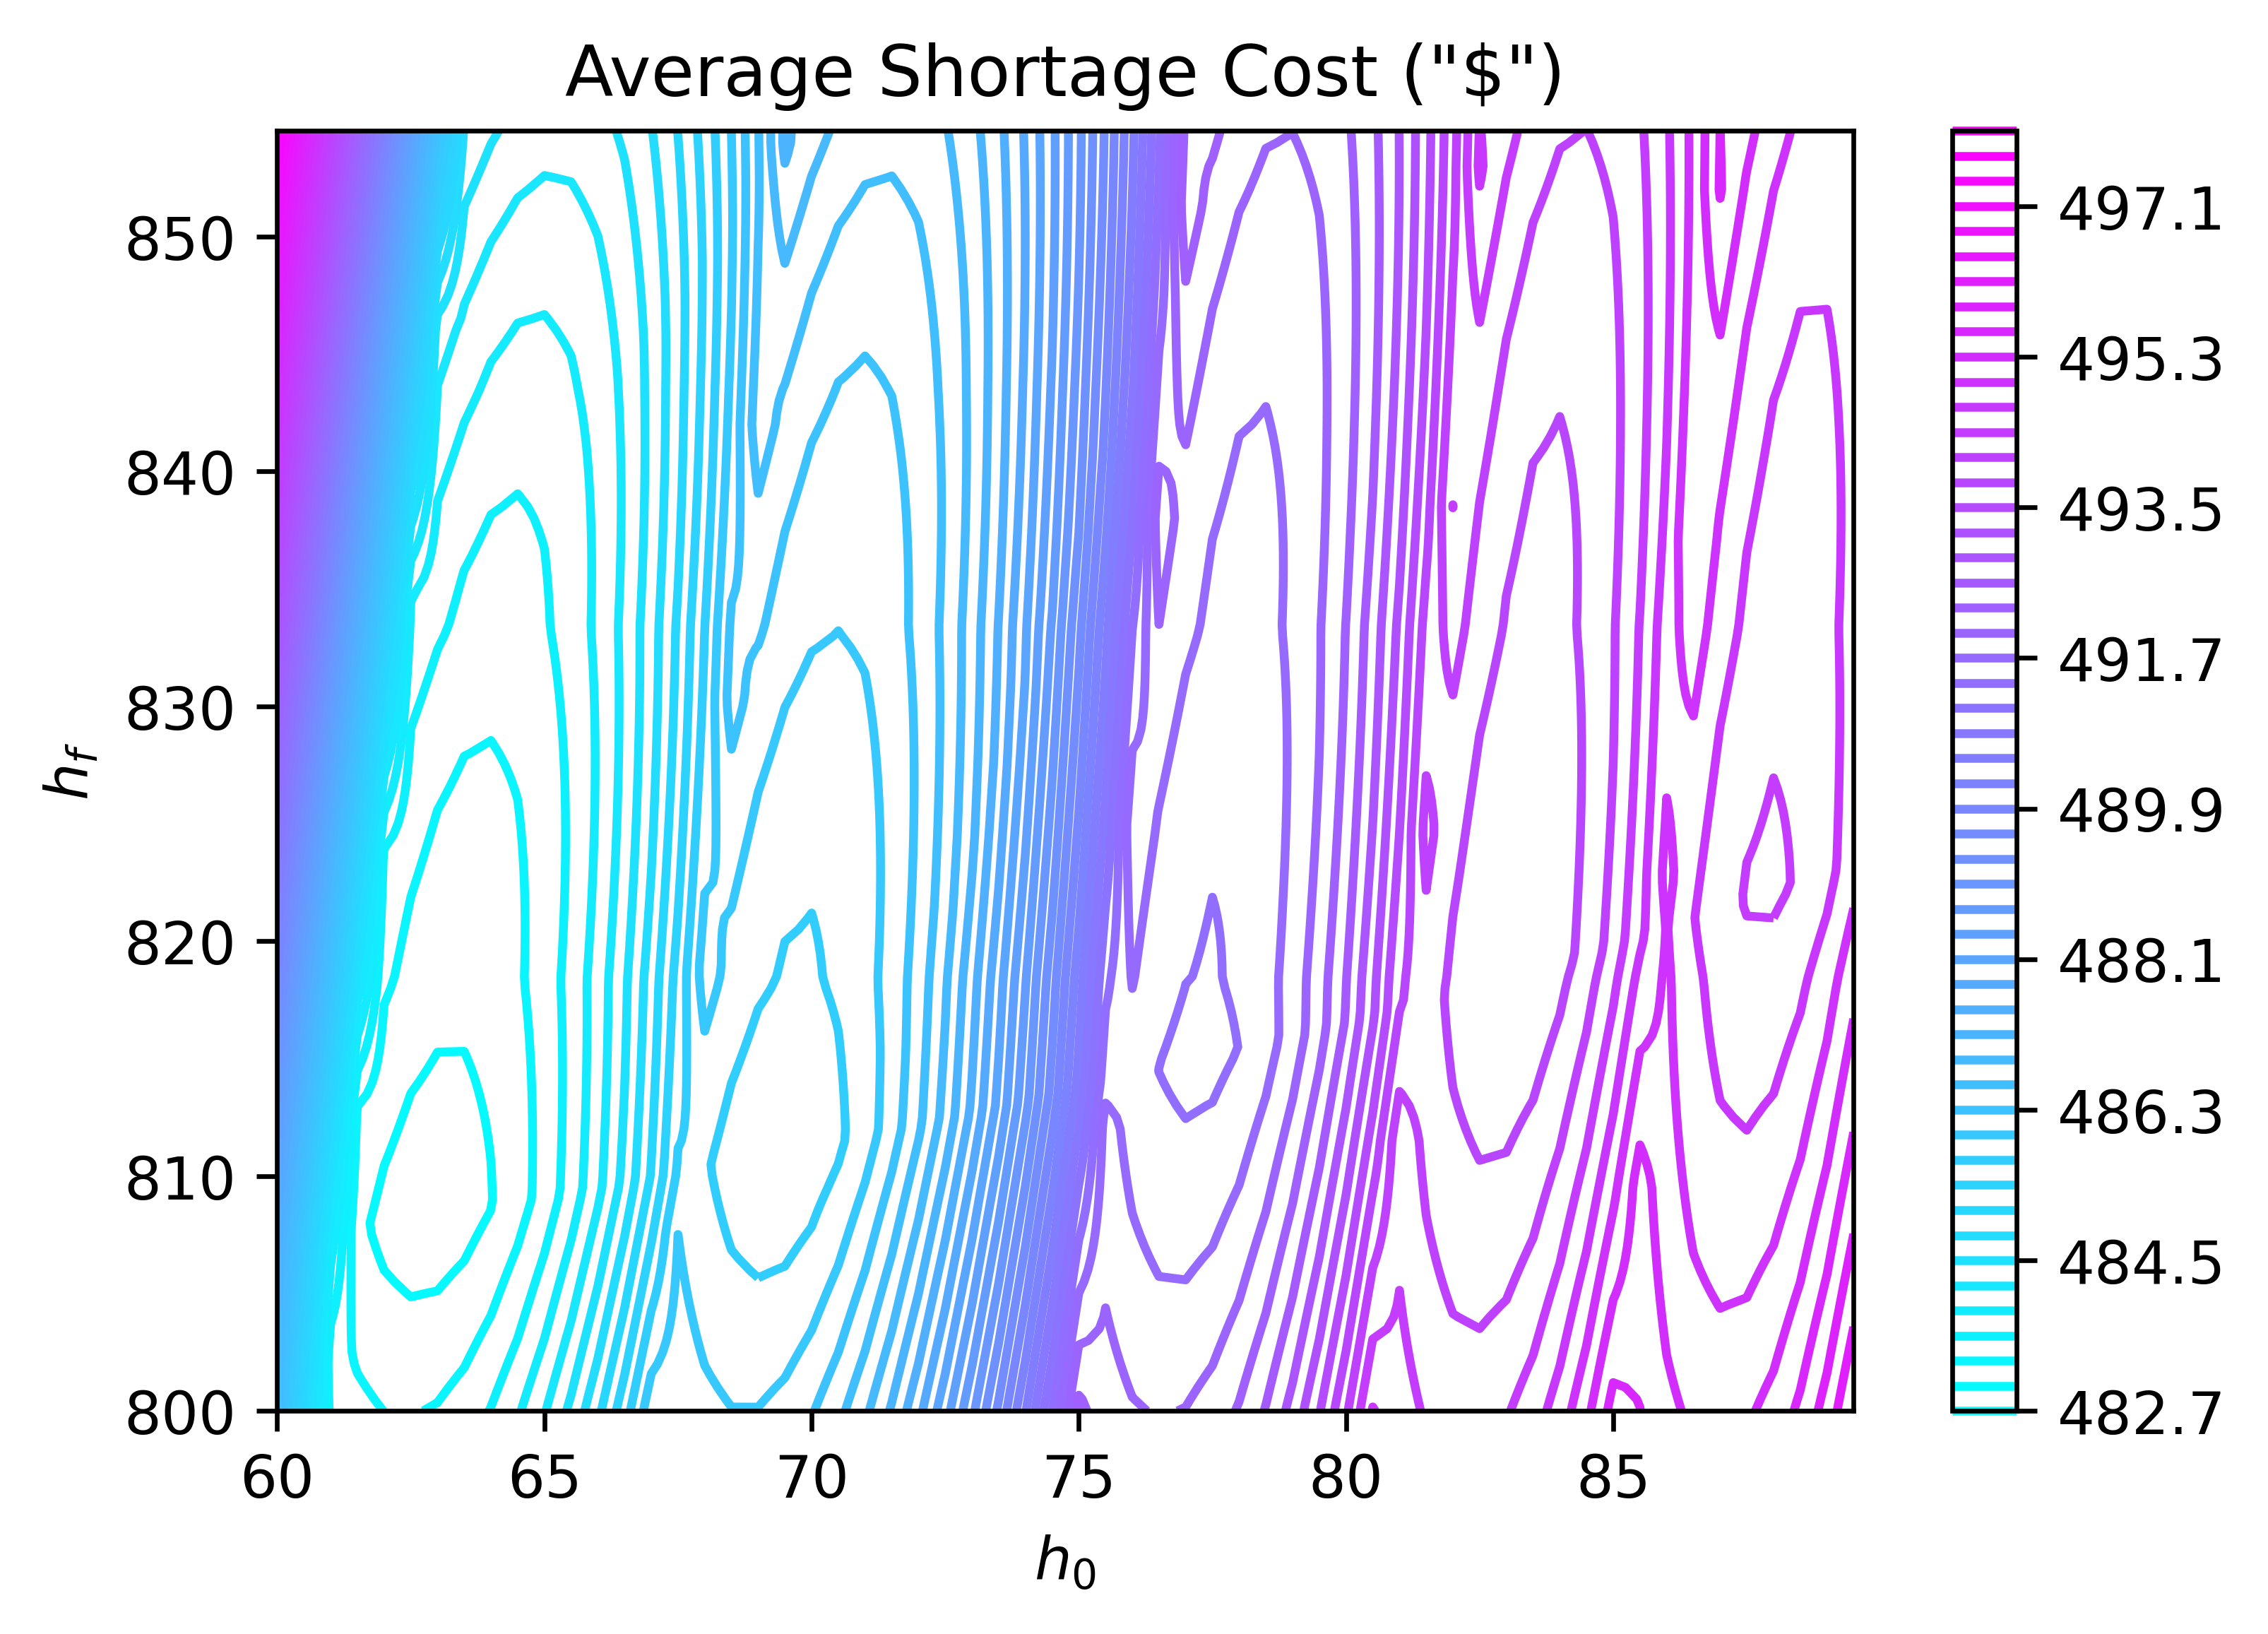

In [52]:
X,Y = np.meshgrid(h0s, hfs)
plt.contour(X,Y,data.T, 50, cmap=plt.cm.cool)
plt.colorbar()
plt.title('Average Shortage Cost ("$")')
plt.xlabel(r'$h_0$')
plt.ylabel(r'$h_f$')
plt.show()

-----------